In [15]:
import pandas as pd
import numpy as np
from IPython.display import display , HTML
import re
from time import sleep, time
import datetime
import matplotlib.pyplot as plt

states = {
'Goa' : [5, 4] 
,'UK' : [28, 7]
,'Manipur' : [14, 6]
,'Punjab' : [19, 12]
,'UP' : [24, 41]
}

ans = {}
start_scan = time()
for sname,snum_pages in states.items():
    start_state = time()
    ans[sname] = []
    snum = snum_pages[0]
    pages = snum_pages[1]
    for pg in range(1, pages+1):
        # if pg>5: break
        url = f"https://results.eci.gov.in/ResultAcGenMar2022/statewiseS{snum:02d}{pg}.htm"
        tbls = pd.read_html(url)
        tbls = [ x for x in tbls if x.shape[1] > 3 ]
        df = pd.read_html(url)[-2]
        # display( f"{sname}-{pg}/{pages}" , url,  [ x.shape for x in tbls  ] )
        for t in tbls[-1:]: 
            # t = t[  [re.match(r"^\d+$", s ) for s in t.iloc[:,1].str] ]
            filt =  [ bool(re.match("^\d+$",str(x)))  for x in t.iloc[:,1]  ]
            t = t[filt]
            t = t.applymap(lambda x: re.sub("iParty Wise.*", "", x) if 'iParty' in str(x) else x)
            # drop last three columns
            t = t.iloc[:,:-3]
            columns = ['Constituency', 'zcnum', 'Leading Candidate', 'Leading Party', 'Trailing Candidate', 'Trailing Party' , 'Margin', 'Status']
            t.columns = columns
            t['State'] = sname
            t = t[['State'] + columns]
            ans[sname].append(t)
            # print (f"{sname} -{pg}/{pages} - {t.shape} - {len(ans[sname])} - {int(time()-start_state)}s - {int(time()-start_scan)}s")


In [16]:
chunav = pd.concat([ pd.concat(dfs, axis=0) for sname, dfs in ans.items()], axis=0)
chunav.Margin = chunav.Margin.apply(lambda x: int(x))
chunav['Leading Party'] = chunav.apply ( lambda x : None if x.Margin == 0 else x['Leading Party'], axis=1)
chunav['Trailing Party'] = chunav.apply ( lambda x : None if x.Margin == 0 else x['Trailing Party'], axis=1)
chunav['Leading Candidate'] = chunav.apply ( lambda x : None if x.Margin == 0 else x['Leading Candidate'], axis=1)
chunav['Trailing Candidate'] = chunav.apply ( lambda x : None if x.Margin == 0 else x['Trailing Candidate'], axis=1)
chunav.to_pickle("./chunav-early-2022.pickle")
winners = chunav['Leading Party'].value_counts().keys()
loosers = chunav['Trailing Party'].value_counts().keys()
ts = datetime.datetime.now().strftime("%b-%d-%Y %H:%M")
display(HTML(f'''
<h1> Chunav Early 2022 </h1> <small>  refreshed {ts} from <a href="https://results.eci.gov.in">eci.gov.in</a>  </small> <hr>
'''))

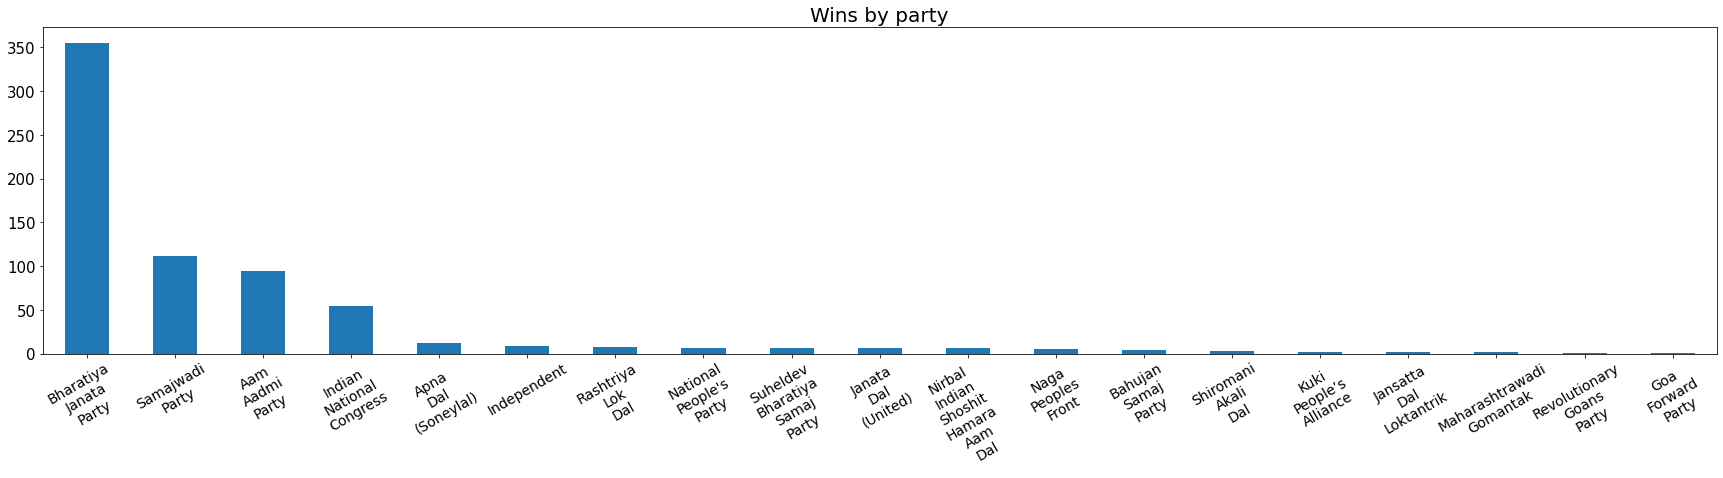

In [17]:
ax = chunav['Leading Party'].value_counts().sort_values(ascending=False).plot(kind='bar', rot=90 , figsize=(30,6), fontsize=15 )
ax.set_title("Wins by party", fontdict={'fontsize': 20})
ax.set_xticklabels( [ "\n".join(w.split()) for w in winners], fontsize=14, rotation=30);

In [18]:
chunav_cnt = pd.pivot_table(chunav, values='Margin', columns=['State'], index=['Leading Party'], aggfunc=len).fillna(0)
chunav_cnt = chunav_cnt.reset_index()
h1 = chunav_cnt.style.format(precision=0).background_gradient(cmap='Blues').applymap(lambda x: 'color: lightgray' if x== 0 else '')\
    .set_caption("<h2>Seats Won</h2>")\
    .hide(axis='index')\
    .to_html()
chunav_margin= pd.pivot_table(chunav, values='Margin', columns=['State'], index=['Leading Party'], aggfunc=np.mean).fillna(0)
h2 = chunav_margin.style.format(precision=0).background_gradient(cmap='Oranges').applymap(lambda x: 'color: lightgray' if x== 0 else '')\
    .set_caption("<h2>Mean Win Margin</h2>") \
    .hide(axis='index')\
    .to_html()

chunav_cnt = pd.pivot_table(chunav, values='Margin', columns=['State'], index=['Leading Party'], aggfunc=len).fillna(0)
chunav_cnt = pd.DataFrame(chunav_cnt.sum(), columns=['']).T
h1t = chunav_cnt.style.format(precision=0).background_gradient(cmap='Blues').applymap(lambda x: 'color: lightgray' if x== 0 else '')\
    .hide(axis='index')\
    .to_html()
chunav_margin= pd.pivot_table(chunav, values='Margin', columns=['State'], index=['Leading Party'], aggfunc=np.mean).fillna(0)
chunav_margin = pd.DataFrame(chunav_margin.sum(), columns=['Party_Total']).T
h2t = chunav_margin.style.format(precision=0).background_gradient(cmap='Oranges').applymap(lambda x: 'color: lightgray' if x== 0 else '')\
    .hide(axis='index')\
    .to_html()

display(HTML(f'''
<table >
    <tr><td>{h1}</td><td>{h2}</td></tr>
    <tr><td style="float:right"> {h1t}</td><td>{h2t}</td></tr>
</table>'''))


Leading Party,Goa,Manipur,Punjab,UK,UP
Aam Aadmi Party,2,0,92,0,0
Apna Dal (Soneylal),0,0,0,0,12
Bahujan Samaj Party,0,0,1,2,1
Bharatiya Janata Party,20,32,2,47,254
Goa Forward Party,1,0,0,0,0
Independent,3,3,1,2,0
Indian National Congress,11,5,18,19,2
Janata Dal (United),0,6,0,0,0
Jansatta Dal Loktantrik,0,0,0,0,2
Kuki People’s Alliance,0,2,0,0,0


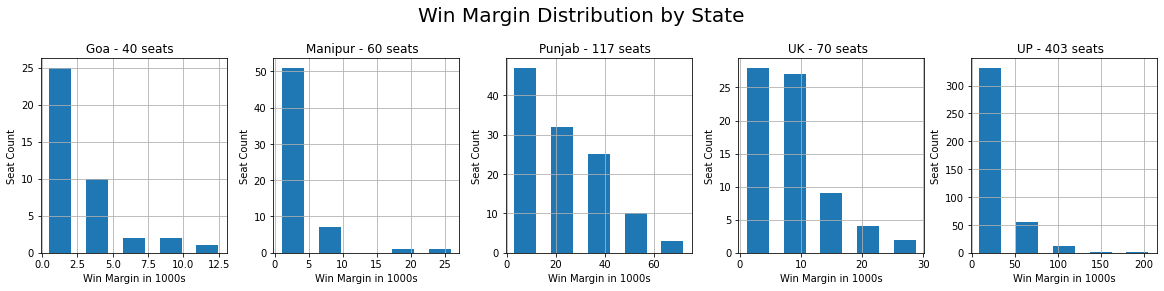

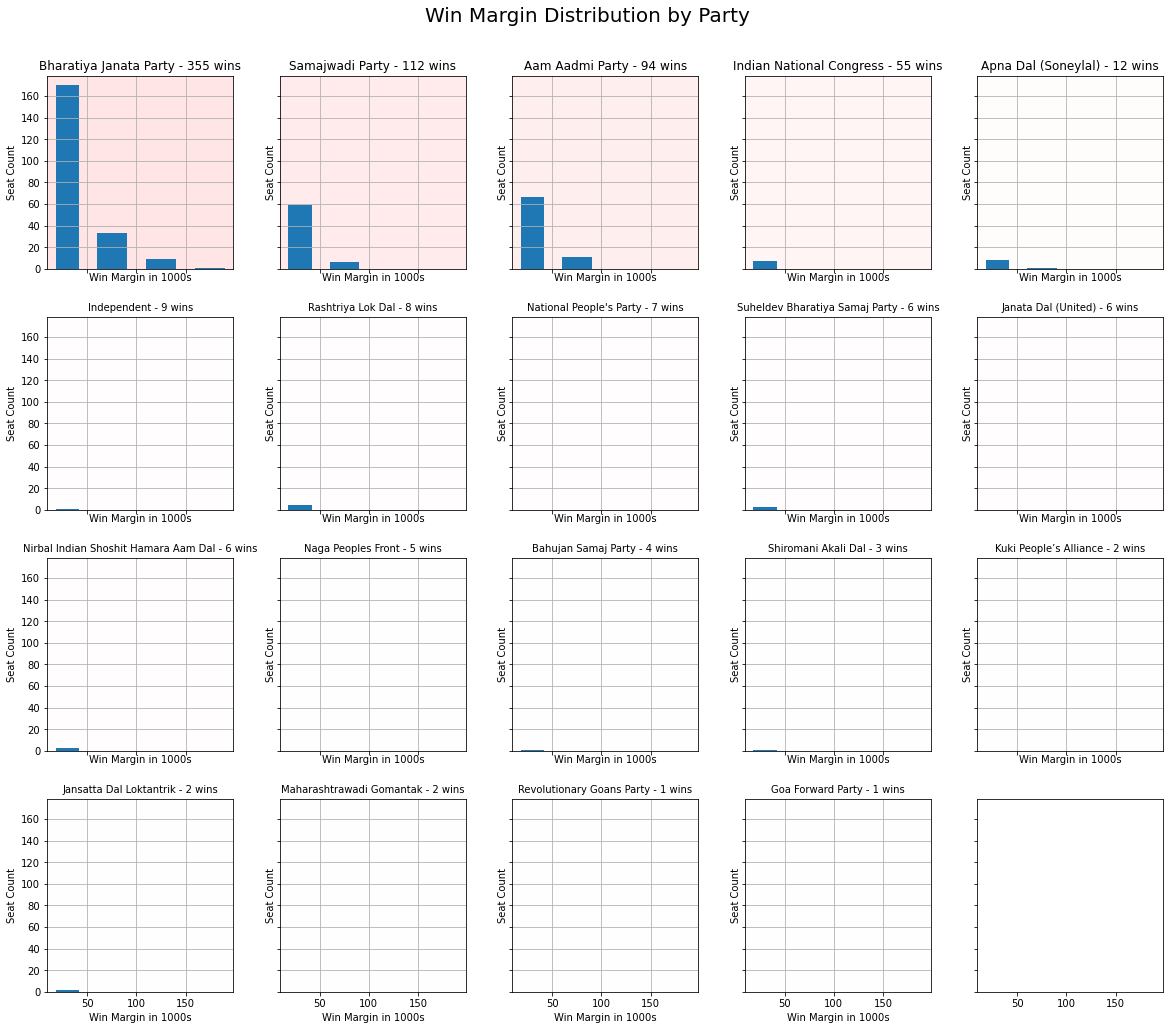

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(20,4), gridspec_kw={'hspace': .5 ,'wspace': 0.25})
axs = axs.flatten()
fig.suptitle('Win Margin Distribution by State', fontsize=20)
plt.subplots_adjust(top=.8)
ix = 0
for st, chunav_grp in chunav.groupby('State'):
    ax = axs[ix] ; ix+=1
    chunav_grp.Margin.apply(lambda x : x//1000).hist(bins=5, rwidth=.6, ax=ax)#(bins=12,figsize=(30,6), rwidth=.6, log=True ) ; #value_counts().sort_index().plot(kind='hist', rot=0 , bins=10, figsize=(30,6), rwidth=.8)
    ax.set_xlabel("Win Margin in 1000s" , fontsize=10)
    ax.set_ylabel("Seat Count")
    win = chunav_grp.shape[0]
    ax.set_title(f"{st} - {win} seats  ", fontsize=12)
    # ax.set_xticks(range(10,210,10))
    # ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=10);

fig, axs = plt.subplots(4, 5, figsize=(20,16), gridspec_kw={'hspace': .25 ,'wspace': 0.25 }, sharex= True, sharey=True)
axs = axs.flatten()
fig.suptitle('Win Margin Distribution by Party', fontsize=20)
plt.subplots_adjust(top=.92)
ix = 0
for st in winners:
    chunav_grp = chunav[chunav['Leading Party'] == st]
# for st, chunav_grp in chunav.groupby('Leading Party')
    ax = axs[ix] ; ix+=1
    chunav_grp.Margin.apply(lambda x : x//1000).hist(bins=[10, 50, 100, 150, 200], rwidth=.6, ax=ax)#(bins=12,figsize=(30,6), rwidth=.6, log=True ) ; #value_counts().sort_index().plot(kind='hist', rot=0 , bins=10, figsize=(30,6), rwidth=.8)
    ax.set_xlabel("Win Margin in 1000s" , fontsize=10)
    ax.set_ylabel("Seat Count")
    win = chunav_grp.shape[0]
    ax.set_title(f"{st} - {win} wins", fontsize=10 if win < 10 else 12)
    # if win > 10 :  ax.set_facecolor('yellow') 
    ax.set_facecolor((1,1-min(1,win/150),1-min(1,win/150),.1))
    # ax.set_xticks(range(10,210,10))
    # ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=10)


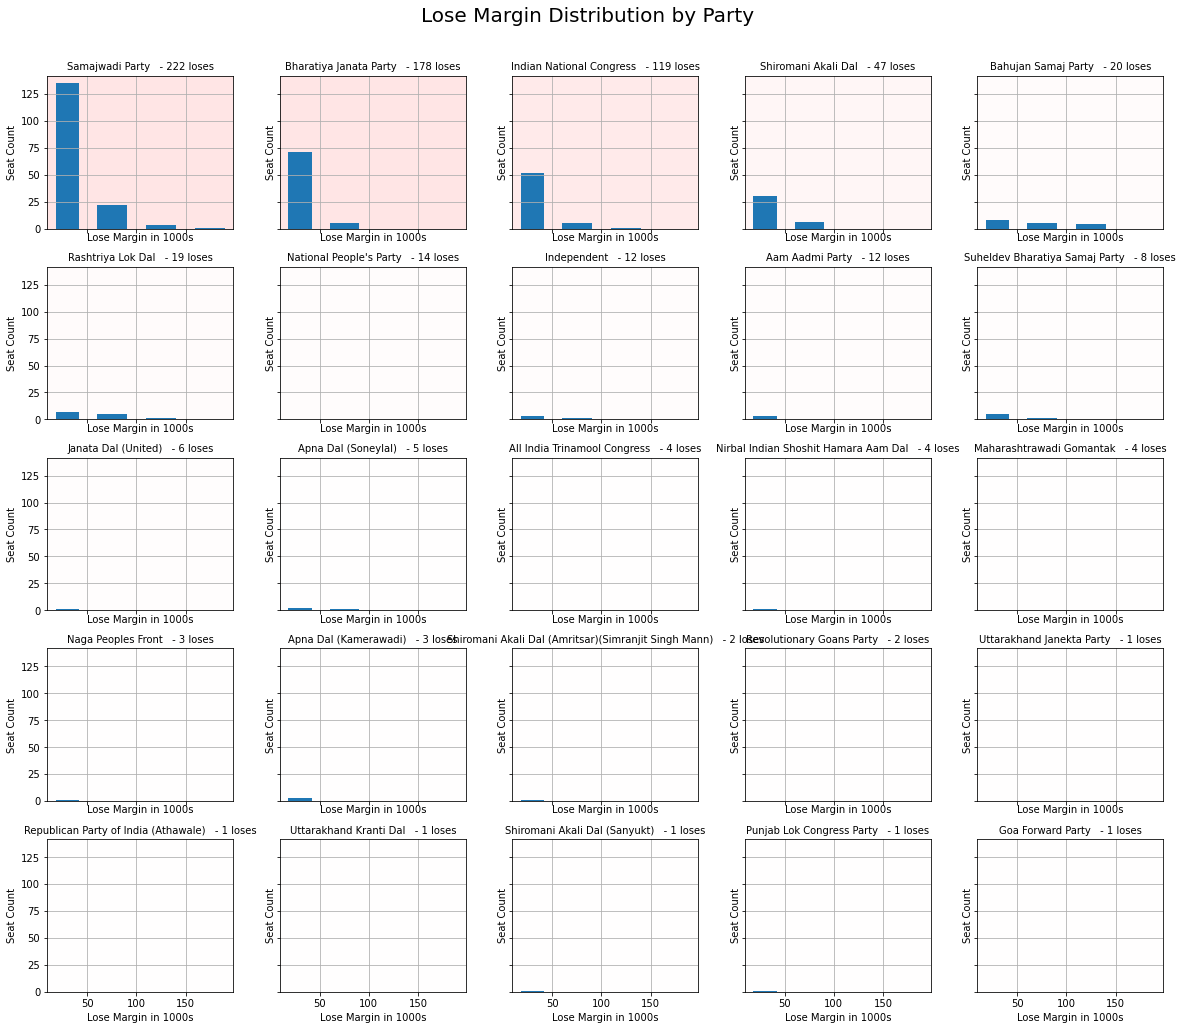

In [20]:
fig, axs = plt.subplots(5, 5, figsize=(20,16), gridspec_kw={'hspace': .25 ,'wspace': 0.25 }, sharex= True, sharey=True)
axs = axs.flatten()
fig.suptitle('Lose Margin Distribution by Party', fontsize=20)
plt.subplots_adjust(top=.92)
ix = 0
for st in loosers:
    if ix > 25: break
    chunav_grp = chunav[chunav['Trailing Party'] == st]
# for st, chunav_grp in chunav.groupby('Leading Party')
    ax = axs[ix] ; ix+=1
    chunav_grp.Margin.apply(lambda x : x//1000).hist(bins=[10, 50, 100, 150, 200], rwidth=.6, ax=ax)#(bins=12,figsize=(30,6), rwidth=.6, log=True ) ; #value_counts().sort_index().plot(kind='hist', rot=0 , bins=10, figsize=(30,6), rwidth=.8)
    ax.set_xlabel("Lose Margin in 1000s" , fontsize=10)
    ax.set_ylabel("Seat Count")
    lose = chunav_grp.shape[0]
    ax.set_title(f"{st} - {lose} loses", fontsize=10 if win < 10 else 12)
    # if win > 10 :  ax.set_facecolor('yellow') 
    ax.set_facecolor((1,1-min(1,lose/150),1-min(1,lose/150),.1))
    # ax.set_xticks(range(10,210,10))
    # ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=10)

In [21]:
chunav = chunav.reset_index().drop(columns=['index'])
lc = chunav['Leading Candidate'].apply( lambda x : str(x).lower())
tc = chunav['Trailing Candidate'].apply( lambda x : str(x).lower())
cn = chunav['Constituency'].apply( lambda x : str(x).lower())

diggaj = pd.Series([
    'amarinder' , 'channi' , 'navjot' ,  'adityanath' , 'badal' , 
    'akhilesh yadav' , 'harish rawat' , 'pushkar' , 'azamgarh' , 'deoband' , 'rajbhar' , 
    'KESHAV PRASAD MAURYA', 'swami prasad' , 'dara' ,'dharam']).apply( lambda x : str(x).lower())

lc1 = lc.apply (lambda x : diggaj.apply( lambda y : y in x).sum() != 0 )
tc1 = tc.apply (lambda x : diggaj.apply( lambda y : y in x).sum() != 0 )
cn1 = cn.apply (lambda x : diggaj.apply( lambda y : y in x).sum() != 0 )


chunav [ cn1 | lc1 | tc1 ].drop(columns=['zcnum']).sort_values('Margin', ascending=False).reset_index().drop(columns=['index']).style.set_caption("<h2>दिग्गज</h2>")


,State,Constituency,Leading Candidate,Leading Party,Trailing Candidate,Trailing Party,Margin,Status
0,UP,Gorakhpur Urban,ADITYANATH,Bharatiya Janata Party,SUBHAWATI UPENDRA DUTT SHUKLA,Samajwadi Party,103390,Result Declared
1,UP,Karhal,Akhilesh Yadav,Samajwadi Party,Prof. S.P. Singh Baghel,Bharatiya Janata Party,67504,Result Declared
2,Punjab,Bathinda Urban,Jagroop Singh Gill,Aam Aadmi Party,Manpreet Singh Badal,Indian National Congress,63581,Result Declared
3,UP,Zahoorabad,OM PRAKASH RAJBHAR,Suheldev Bharatiya Samaj Party,KALICHARAN,Bharatiya Janata Party,45632,Result Declared
4,UP,Fazilnagar,Surendra Kumar Kushwaha,Bharatiya Janata Party,Swami Prasad Maurya,Samajwadi Party,45014,Result Declared
5,Punjab,Bhadaur,LABH SINGH UGOKE,Aam Aadmi Party,CHARANJIT SINGH CHANNI,Indian National Congress,37558,Result Declared
6,Punjab,Jalalabad,JAGDEEP KAMBOJ,Aam Aadmi Party,Sukhbir Singh Badal,Shiromani Akali Dal,30930,Result Declared
7,Punjab,Dharamkot,DEVINDERJEET SINGH LADDI DHOSE,Aam Aadmi Party,SUKHJIT SINGH KAKA LOHGARH,Indian National Congress,29972,Result Declared
8,UP,Shivpur,Anil Rajbhar,Bharatiya Janata Party,Arvind Rajbhar,Suheldev Bharatiya Samaj Party,27687,Result Declared
9,UP,Ghosi,DARA SINGH CHAUHAN,Samajwadi Party,VIJAY KUMAR RAJBHAR,Bharatiya Janata Party,22216,Result Declared


In [22]:
chunav.sort_values('Margin', ascending=False).reset_index().drop(columns=['index' , 'zcnum']).head(50).style.set_caption("<h2>Big Winners</h2>")

,State,Constituency,Leading Candidate,Leading Party,Trailing Candidate,Trailing Party,Margin,Status
0,UP,Sahibabad,SUNIL KUMAR SHARMA,Bharatiya Janata Party,AMARPAL SHARMA,Samajwadi Party,214835,Result Declared
1,UP,Noida,Pankaj Singh,Bharatiya Janata Party,Sunil Choudhary,Samajwadi Party,181513,Result Declared
2,UP,Dadri,TEJPAL SINGH NAGAR,Bharatiya Janata Party,RAJKUMAR BHATI,Samajwadi Party,138218,Result Declared
3,UP,Meerut Cantt.,AMIT AGARWAL,Bharatiya Janata Party,MANISHA AHLAWAT,Rashtriya Lok Dal,118072,Result Declared
4,UP,Agra North,PURUSHOTTAM KHANDELWAL,Bharatiya Janata Party,SHABBIR ABBAS,Bahujan Samaj Party,112370,Result Declared
5,UP,Mehroni,Manohar Lal,Bharatiya Janata Party,Kiran Ramesh Khatik,Bahujan Samaj Party,110451,Result Declared
6,UP,Mathura,SHRIKANT SHARMA,Bharatiya Janata Party,PRADEEP MATHUR,Indian National Congress,109803,Result Declared
7,UP,Lalitpur,Ramratan Kushwaha,Bharatiya Janata Party,Chandra Bhusan Singh Bundela (Guddu Raja),Bahujan Samaj Party,107215,Result Declared
8,UP,Ghaziabad,Atul Garg,Bharatiya Janata Party,Vishal Verma,Samajwadi Party,105537,Result Declared
9,UP,Gorakhpur Urban,ADITYANATH,Bharatiya Janata Party,SUBHAWATI UPENDRA DUTT SHUKLA,Samajwadi Party,103390,Result Declared


In [23]:
chunav.sort_values('Margin', ascending=True).reset_index().drop(columns=['index' , 'zcnum']).head(50).style.set_caption("<h2>Tight Winners</h2>")

,State,Constituency,Leading Candidate,Leading Party,Trailing Candidate,Trailing Party,Margin,Status
0,Manipur,Wabgai,Dr.USHAM DEBEN SINGH,Bharatiya Janata Party,MD.FAJUR RAHIM,Indian National Congress,50,Result Declared
1,Goa,St. Andre,Viresh Mukesh Borkar,Revolutionary Goans Party,Francisco Silveira,Bharatiya Janata Party,76,Result Declared
2,Goa,Ponda,RAVI NAIK,Bharatiya Janata Party,KETAN PRABHU BHATIKAR,Maharashtrawadi Gomantak,77,Result Declared
3,Manipur,Lamlai,Khongbantabam Ibomcha,Bharatiya Janata Party,Kshetrimayum Biren Singh,Janata Dal (United),121,Result Declared
4,UK,Almora,MANOJ TEWARI,Indian National Congress,KAILASH SHARMA,Bharatiya Janata Party,141,Result in Progress
5,Goa,Velim,CRUZ SILVA,Aam Aadmi Party,D'SILVA SAVIO,Indian National Congress,169,Result Declared
6,UK,Dwarahat,MADAN SINGH BISHT,Indian National Congress,ANIL SINGH SHAHI,Bharatiya Janata Party,182,Result Declared
7,Manipur,Keisamthong,SAPAM NISHIKANT SINGH,Independent,Maheshwar Thounaojam,Republican Party of India (Athawale),187,Result Declared
8,UP,Dhampur,ASHOK KUMAR RANA,Bharatiya Janata Party,NAIM UL HASAN,Samajwadi Party,203,Result Declared
9,Goa,Priol,Govind Shepu Gaude,Bharatiya Janata Party,Pandurang Alias Deepak Dhavalikar,Maharashtrawadi Gomantak,213,Result Declared


In [24]:
chunav.drop(columns=['zcnum']).to_csv('./chunav-early-2022.csv')

In [25]:
!rm ./chunav-early-2022.html 2>/dev/null
!date

!`which jupyter` nbconvert chunav-early-2022.ipynb --to html --no-input --output  chunav-early-2022.html 2>&1 | tee ~/tmp/nbconvert.log
!open ./chunav-early-2022.html

Fri Mar 11 00:09:43 IST 2022
[NbConvertApp] Converting notebook chunav-early-2022.ipynb to html
[NbConvertApp] Writing 985665 bytes to chunav-early-2022.html


In [ ]:

# ans = {}
# for sname,snum_pages in states.items():
#     snum = snum_pages[0]
#     url = f"https://results.eci.gov.in/ResultAcGenMar2022/partywiseresult-S{snum:02d}.htm"
#     pages = snum_pages[1]
#     # print(sname)
#     tbls = pd.read_html(url)

#     df = pd.read_html(url)[-1]
#     df.columns =  df.iloc[2].to_list()
#     df = df.iloc[3:,].set_index(['Party'])
#     # set dtype to int
#     df = df.iloc[:,:].apply(lambda x: x.astype(int))
#     df = df.sort_values(by=['Won', 'Leading'], ascending=False).drop('Total')
#     df = df.T
#     df['Total'] = df.apply(lambda x: int(x.sum()), axis=1)
#     df = df.T
#     ans[sname] = df
#     # set gradient style
#     df.style.background_gradient(cmap='Reds', low=0, high=100)
#     # display(df.style.set_caption(f"<h2>{sname}</h2>").background_gradient(cmap='YlOrRd', low=20, high=44))
#     display(df.style.set_caption(f"<h2>{sname}</h2>").bar(subset=['Total']))

# display dataframe side by side

    